In [ ]:
!pip install opencv-python numpy pandas matplotlib scikit-learn tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


***Data Exploration***

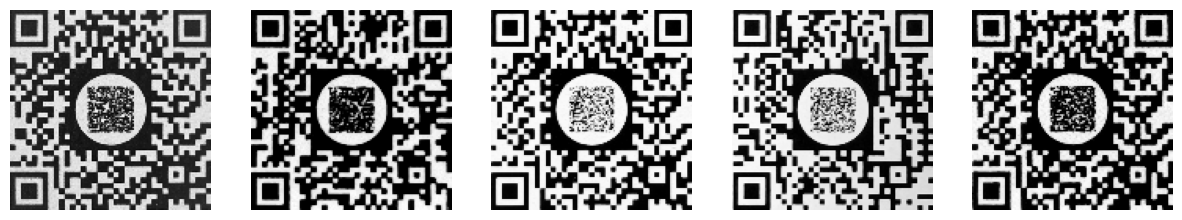

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Set dataset paths
dataset_path = "/content/drive/MyDrive/Assignment Data"

# Read images
def load_images(path):
    images, labels = [], []
    for label in ["First Print", "Second Print"]:
        folder_path = os.path.join(path, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img = cv2.resize(img, (128, 128))  # Resize to a standard size
            images.append(img_to_array(img) / 255.0)  # Normalize
            labels.append(0 if label == "First Print" else 1)
    return np.array(images), np.array(labels)

X, y = load_images(dataset_path)
X = X.reshape(-1, 128, 128, 1)  # Reshape for CNN input
y = to_categorical(y, 2)  # Convert labels to categorical

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display some images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(128, 128), cmap="gray")
    ax.axis("off")
plt.show()


***Feature Engineering***

In [ ]:
def extract_features(image):
    # Ensure image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert image to 8-bit or floating-point format
    image = image.astype(np.uint8)  # Use np.float32 if needed

    # Feature extraction
    laplacian = cv2.Laplacian(image, cv2.CV_64F).var()  # Sharpness detection
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5).var()  # Edge detection (X)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5).var()  # Edge detection (Y)

    return [laplacian, sobelx, sobely]

# Extract features correctly
X_features = np.array([extract_features(img.reshape(128, 128)) for img in X])


***Model Development***

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Binary classification
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

print(classification_report(y_test_cnn, y_pred_cnn))
print("Confusion Matrix:\n", confusion_matrix(y_test_cnn, y_pred_cnn))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 929ms/step - accuracy: 0.4737 - loss: 1.0120 - val_accuracy: 0.4750 - val_loss: 0.7096
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 852ms/step - accuracy: 0.5376 - loss: 0.6758 - val_accuracy: 0.6500 - val_loss: 0.6718
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 832ms/step - accuracy: 0.6990 - loss: 0.6676 - val_accuracy: 0.8250 - val_loss: 0.6432
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step - accuracy: 0.5979 - loss: 0.6585 - val_accuracy: 0.4750 - val_loss: 0.6316
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.7424 - loss: 0.5765 - val_accuracy: 0.9250 - val_loss: 0.4827
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 781ms/step - accuracy: 0.7868 - loss: 0.4896 - val_accuracy: 0.9000 - val_loss: 0.3794
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.8120 - loss: 0.4723 - val_accuracy: 0.9000 - val_loss: 0.3026
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 801ms/step - accuracy: 0.8916 - loss: 0.3199 - val_accuracy: 0.9250 - val_loss: 0.2506
Epo

***Evaluation and Results***

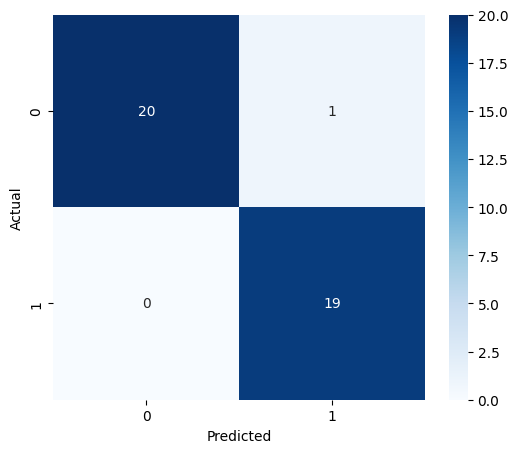

In [ ]:
import seaborn as sns

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
